In [1]:
import numpy as np
from scipy import integrate
from scipy import optimize

# some constants
G = 6.67428e-11   
solarmass = 1.98892e30 # mass of sun
h = 0.6774            # hubble constant 
c = 2.99792458e8            #speed of light
pc2m = 3.086e16      # 1 pc = 3.086e16 m 
year = 3.154e7 # 1 year in seconds
pi = np.pi
loge = np.log
log10 = np.log10

import matplotlib as mpl
import matplotlib.pyplot as plt
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import mass_function

cosmology.setCosmology('planck18')

mmin = -1
mmax = 8

hmf_mass = np.logspace(mmin,mmax,(mmax-mmin)*100)
hmf_dndlnm = mass_function.massFunction(hmf_mass, z = 0.0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

MyCon = concentration.concentration(hmf_mass, mdef = '200c', z = 0.0, model = 'prada12')

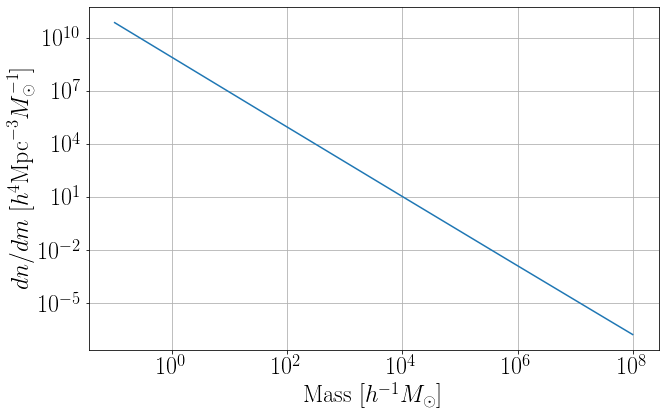

In [3]:
plt.plot(hmf_mass,hmf_dndlnm/hmf_mass)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass $[h^{-1}M_\odot]$")
plt.ylabel(r"$dn/dm$  $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$");

Text(0, 0.5, 'c')

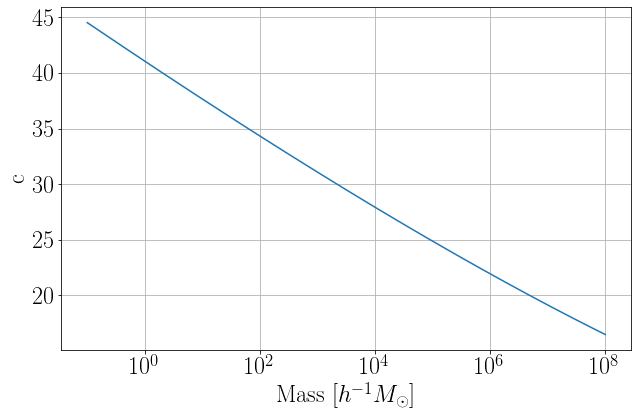

In [4]:
plt.plot(hmf_mass,MyCon)
plt.xscale('log')
plt.xlabel(r"Mass $[h^{-1}M_\odot]$")
plt.ylabel(r"c")

In [5]:
def NFWparams(m_halo,concentration): 
    '''
    NFW Dark matter profile. 
    
    Input: 
    m_halo, the total mass of the dark matter halo (unit: M_sun) 
    concentration parameter (from c-M_200 relation)
    
    Output: 
    Rvir: pc
    Rs: pc
    Rhos: Msun/pc^3
    ''' 
               
    #NFW halo parameters:
    rho_critical = 2.775 * h*h * 1e11 / (1e18) # unit: M_sun/pc^3
    Rvir =  ( m_halo / (200.*rho_critical) / (4.*pi /3) )**(1./3) #pc
    Rs = Rvir / concentration #unit: pc
    Rhos = m_halo/(4.*pi*Rs**3) / (loge(1+concentration)-concentration/(1.+concentration)) #unit: M_sun/ pc^3
    
    return Rs,Rhos,Rvir

In [6]:
def gfunction(C):
    return loge(1+C) - C/(1+C)

def PfunctionIntegrand(v,v_vir,con):
    '''
    v: m/s
    v_vir: m/s
    '''
    v_dm = v_vir/np.sqrt(2) * np.sqrt(con/2.1612 * gfunction(2.1626)/gfunction(con))
    return np.exp(-v**2/v_dm**2) - np.exp(-v_vir**2/v_dm**2)    

def PNormIntegrand(v,v_vir,con):
    '''
    v: m/s
    v_vir: m/s
    '''
    return PfunctionIntegrand(v,v_vir,con)*4*pi*v**2

def DfunctionIntegrand(v,v_vir,con):
    '''
    v: m/s
    v_vir: m/s
    '''
    return PfunctionIntegrand(v,v_vir,con)*(2*v/c)**(3/7)

In [7]:
MyRs,MyRhos,MyRvir = NFWparams(hmf_mass/h,MyCon)

In [8]:
MyV_vir = np.sqrt(G* hmf_mass/h * solarmass / MyRvir/pc2m ) #unit: m/s

Text(0.5, 0, 'Mass $[h^{-1}M_\\odot]$')

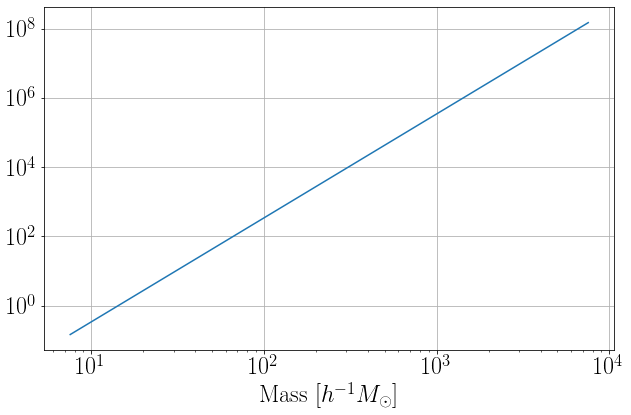

In [9]:
plt.plot(MyV_vir,hmf_mass/h)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Mass $[h^{-1}M_\odot]$")

In [10]:
Pnorm = []
for i in range(len(MyV_vir)):
    cache,err =integrate.quad(PNormIntegrand,0,MyV_vir[i],  args=(MyV_vir[i],MyCon[i]))
    Pnorm.append(cache)
Pnorm = np.array(Pnorm)

In [11]:
Dresult = []
for i in range(len(MyV_vir)):
    cache,err = integrate.quad(DfunctionIntegrand,0,MyV_vir[i],  args=(MyV_vir[i],MyCon[i]) )
    Dresult.append(cache)
Dresult = np.array(Dresult)
Dresult = Dresult/Pnorm

In [12]:
RatePerHalo = (85*pi/6/np.sqrt(2))**(2/7)*2*pi/3\
                *G**2*(hmf_mass/h*solarmass)**2/c/ (MyRs*pc2m)**3\
                *(1-1/(1+MyCon)**3)*Dresult/gfunction(MyCon)**2 * year

In [13]:
hmf_dndm = hmf_dndlnm/hmf_mass
index = 0
np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1])) *h**3 * 1e9

796.957884642753

In [14]:
index = np.where(hmf_mass/h>1)[0][0]
np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1])) *h**3 * 1e9

265.3524164138793

In [15]:
index = np.where(hmf_mass/h>10)[0][0]
np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1])) *h**3 * 1e9

70.0673214483135

In [16]:
index = np.where(hmf_mass/h>100)[0][0]
np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1])) *h**3 * 1e9

18.3806139618901

In [17]:
rate = []
for i,val in enumerate(hmf_mass/h):
    index = np.where(hmf_mass/h>=val)[0][0]
    rate.append(np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9)

In [ ]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(hmf_mass/h,rate,lw=2,color='black',alpha=0.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-1/h,1e8)
ax.set_ylim(1e-3,1e3)
ax.set_xlabel(r'$M^\mathrm{low}_\mathrm{vir}~[M_\odot]$')
ax.set_ylabel(r'$\mathcal{R}_\mathrm{PBH}~[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}]$')

index = np.where(hmf_mass/h>0.3)[0][0]
print(np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9)
ax.scatter(0.3,np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9,
          marker='D',label=r'$M_\mathrm{PBH}=0.01 M_\odot$')

index = np.where(hmf_mass/h>3)[0][0]
print(np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9)
ax.scatter(3,np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9,
          marker='^',label=r'$M_\mathrm{PBH}=0.1 M_\odot$')

cutoffmass = 21
index = np.where(hmf_mass/h>cutoffmass)[0][0]
print(np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9)
ax.scatter(cutoffmass,np.sum(RatePerHalo[index:-1]*hmf_dndm[index:-1]*(hmf_mass[index+1:]-hmf_mass[index:-1]))*h**3* 1e9,
           marker='o',label=r'$M_\mathrm{PBH}=1 M_\odot$')

ax.legend()
fig.savefig('./../1-Manuscript/figures/fig1-Rpbh.pdf',bbox_inches='tight')

The event rates for 0.01/0.1/1 solar mass PBH binary are:
528.7996034996036
140.16286269528348
45.08220791741155

# Mass lower limit & evaporation time

In [20]:
MyV_dm = MyV_vir/np.sqrt(2) * np.sqrt(MyCon/2.1612 * gfunction(2.1626)/gfunction(MyCon))

In [40]:
lowmass = 21
index = np.where(hmf_mass/h>lowmass)[0][0]
N = lowmass/1
14*N/loge(N)*MyRvir[index]*pc2m/MyCon[index]/MyV_dm[index]/year

3064075510.71679

In [41]:
lowmass = 3
index = np.where(hmf_mass/h>lowmass)[0][0]
N = lowmass/0.1
14*N/loge(N)*MyRvir[index]*pc2m/MyCon[index]/MyV_dm[index]/year

3548337954.663069

In [42]:
lowmass = 0.3
index = np.where(hmf_mass/h>lowmass)[0][0]
N = lowmass/0.01
14*N/loge(N)*MyRvir[index]*pc2m/MyCon[index]/MyV_dm[index]/year

3178312985.6849136

# Figure out the PBH relative velocity distribution

In [90]:
MyV_dm = MyV_vir/np.sqrt(2) * np.sqrt(MyCon/2.1612 * gfunction(2.1626)/gfunction(MyCon))

In [91]:
############# Note that the bin step length is 1 ############
vrel_bin = np.linspace(0,8000,8001)
#We think the largest virial velocity is 8000 m/s

In [92]:
index = np.where(hmf_mass/h>30)[0][0]
vrel_dist = np.zeros(len(vrel_bin))

for i in range(index,len(MyV_vir)-1,1):
#for dark matter halo with a particular mass
    vrelintegralbin = np.linspace(0,np.floor(MyV_vir[i]),int(np.floor(MyV_vir[i]))+1) #v step length = 1
    halonum = (85*pi/6/np.sqrt(2))**(2/7)*2*pi/3\
                *G**2*(hmf_mass[i]/h*solarmass)**2/c/ (MyRs[i]*pc2m)**3\
                *(1-1/(1+MyCon[i])**3)*DfunctionIntegrand(vrelintegralbin,MyV_vir[i],MyCon[i])/Pnorm[i]\
                /gfunction(MyCon[i])**2 * year *hmf_dndm[i]*(hmf_mass[i+1]-hmf_mass[i])*h**3 * 1e9
    for k in range(len(vrelintegralbin)):
        vrel_dist[k] += halonum[k]

In [93]:
np.sum(vrel_dist)

36.82902869025923

(1.0, 8000.0)

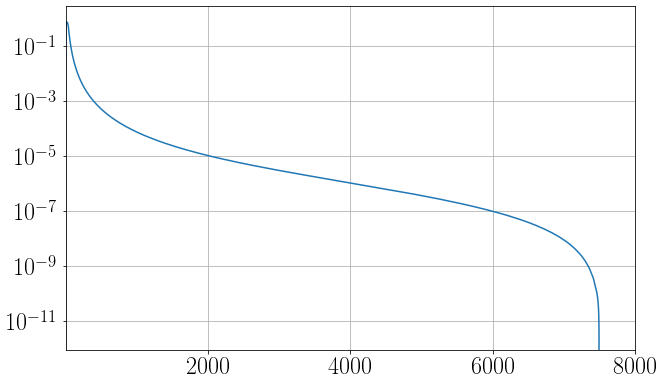

In [97]:
plt.plot(vrel_bin,vrel_dist)
plt.yscale('log')
plt.xlim(1,8000)
#plt.ylim(0.01,100)

In [195]:
np.savetxt('PBHmass1vdist.txt',np.transpose([vrel_bin,vrel_dist]),header='v [m/s]    dN/dv')

In [98]:
index = np.where(hmf_mass/h>3)[0][0]
vrel_dist = np.zeros(len(vrel_bin))

for i in range(index,len(MyV_vir)-1,1):
#for dark matter halo with a particular mass
    vrelintegralbin = np.linspace(0,np.floor(MyV_vir[i]),int(np.floor(MyV_vir[i]))+1) #v step length = 1
    halonum = (85*pi/6/np.sqrt(2))**(2/7)*2*pi/3\
                *G**2*(hmf_mass[i]/h*solarmass)**2/c/ (MyRs[i]*pc2m)**3\
                *(1-1/(1+MyCon[i])**3)*DfunctionIntegrand(vrelintegralbin,MyV_vir[i],MyCon[i])/Pnorm[i]\
                /gfunction(MyCon[i])**2 * year *hmf_dndm[i]*(hmf_mass[i+1]-hmf_mass[i])*h**3 * 1e9
    for k in range(len(vrelintegralbin)):
        vrel_dist[k] += halonum[k]
        
np.sum(vrel_dist)
np.savetxt('PBHmass0p1vdist.txt',np.transpose([vrel_bin,vrel_dist]),header='v [m/s]    dN/dv')

139.51802813156735

In [99]:
index = np.where(hmf_mass/h>0.3)[0][0]
vrel_dist = np.zeros(len(vrel_bin))

for i in range(index,len(MyV_vir)-1,1):
#for dark matter halo with a particular mass
    vrelintegralbin = np.linspace(0,np.floor(MyV_vir[i]),int(np.floor(MyV_vir[i]))+1) #v step length = 1
    halonum = (85*pi/6/np.sqrt(2))**(2/7)*2*pi/3\
                *G**2*(hmf_mass[i]/h*solarmass)**2/c/ (MyRs[i]*pc2m)**3\
                *(1-1/(1+MyCon[i])**3)*DfunctionIntegrand(vrelintegralbin,MyV_vir[i],MyCon[i])/Pnorm[i]\
                /gfunction(MyCon[i])**2 * year *hmf_dndm[i]*(hmf_mass[i+1]-hmf_mass[i])*h**3 * 1e9
    for k in range(len(vrelintegralbin)):
        vrel_dist[k] += halonum[k]
        
np.sum(vrel_dist)
np.savetxt('PBHmass0p01vdist.txt',np.transpose([vrel_bin,vrel_dist]),header='v [m/s]    dN/dv')

In [100]:
index = np.where(hmf_mass/h>15)[0][0]
vrel_dist = np.zeros(len(vrel_bin))

for i in range(index,len(MyV_vir)-1,1):
#for dark matter halo with a particular mass
    vrelintegralbin = np.linspace(0,np.floor(MyV_vir[i]),int(np.floor(MyV_vir[i]))+1) #v step length = 1
    halonum = (85*pi/6/np.sqrt(2))**(2/7)*2*pi/3\
                *G**2*(hmf_mass[i]/h*solarmass)**2/c/ (MyRs[i]*pc2m)**3\
                *(1-1/(1+MyCon[i])**3)*DfunctionIntegrand(vrelintegralbin,MyV_vir[i],MyCon[i])/Pnorm[i]\
                /gfunction(MyCon[i])**2 * year *hmf_dndm[i]*(hmf_mass[i+1]-hmf_mass[i])*h**3 * 1e9
    for k in range(len(vrelintegralbin)):
        vrel_dist[k] += halonum[k]
        
np.sum(vrel_dist)
np.savetxt('PBHmass0p5vdist.txt',np.transpose([vrel_bin,vrel_dist]),header='v [m/s]    dN/dv')

# Figure 2

In [20]:
v0p01 = np.loadtxt('./data/PBHmass0p01vdist.txt')
v0p1 = np.loadtxt('./data/PBHmass0p1vdist.txt')
v1 = np.loadtxt('./data/PBHmass1vdist.txt')

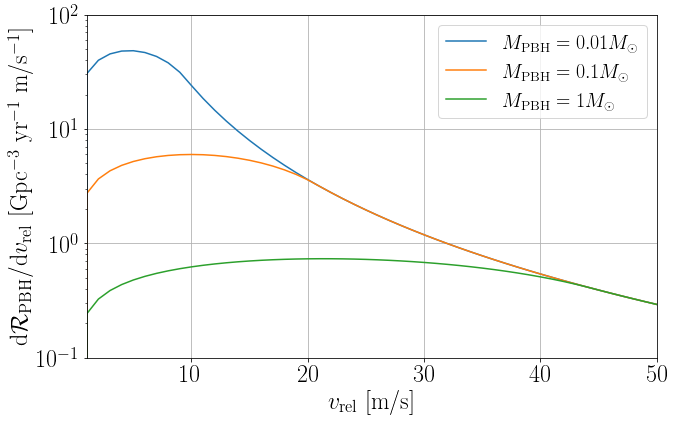

In [25]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(v0p01[:,0],v0p01[:,1],label=r'$M_\mathrm{PBH}=0.01 M_\odot$')
ax.plot(v0p01[:,0],v0p1[:,1],label=r'$M_\mathrm{PBH}=0.1 M_\odot$')
ax.plot(v0p01[:,0],v1[:,1],label=r'$M_\mathrm{PBH}=1 M_\odot$')


ax.set_yscale('log')
ax.set_xlabel(r'$v_\mathrm{rel}$ [m/s]')
ax.set_ylabel(r'$\mathrm{d} \mathcal{R}_\mathrm{PBH}/\mathrm{d}v_\mathrm{rel}$ [Gpc$^{-3}$ yr$^{-1}$ m/s$^{-1}]$')
ax.set_xlim(1,50)
ax.set_ylim(1e-1,100)
ax.legend()
fig.savefig('./../1-Manuscript/figures/fig2-dRdv.pdf',bbox_inches='tight')